In [94]:
!sudo add-apt-repository --remove ppa:vikoadi/ppa -y
!sudo apt update

Repository: 'deb https://ppa.launchpadcontent.net/vikoadi/ppa/ubuntu/ jammy main'
Description:
Contains :
* KDE Connect Indicator for Ubuntu and elementary OS, for information please read http://vikoadi.blogspot.com
* latest KDE Connect Package
More info: https://launchpad.net/~vikoadi/+archive/ubuntu/ppa
Removing repository.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:1

In [95]:
!pip install pyspark
!pip install nltk
!pip install wordcloud

In [96]:
import gdown
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, ArrayType
from pyspark.sql.functions import col, udf, split, explode, size, array_remove, array_contains, regexp_replace, lower
from pyspark.ml.feature import StopWordsRemover, Tokenizer, HashingTF, IDF, CountVectorizer, NGram
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [97]:
file_id = '1w2c49UUWnZHbWZ_ryKaWGhIzSF7QuvYJ'
url = f'https://drive.google.com/uc?id={file_id}'
output_path = '/content/mental_health.csv'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)
else:
    print(f"The file '{output_path}' already exists.")

The file '/content/mental_health.csv' already exists.


In [98]:
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder\
        .master("local")\
        .appName("RDD")\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.memory', '4g')\
        .config('spark.driver.memory', '4g')\
        .getOrCreate()

spark
sc = spark.sparkContext
sc.setCheckpointDir('checkpoint/')

In [99]:
spark.conf.set("spark.sql.shuffle.partitions", 16)
spark.conf.set("spark.default.parallelism", 16)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 104857600)

In [100]:
df = spark.read.csv(output_path, header=True, inferSchema=True)

In [101]:
df.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|dear american tee...|    0|
|nothing look forw...|    1|
|music recommendat...|    0|
|im done trying fe...|    1|
|worried  year old...|    1|
+--------------------+-----+
only showing top 5 rows



In [102]:
# Display summary statistics for numerical columns
df.describe().show()

# Display the schema of the DataFrame
df.printSchema()

+-------+--------------------+-------------------+
|summary|                text|              label|
+-------+--------------------+-------------------+
|  count|               27977|              27977|
|   mean|                NULL|0.49462058119169316|
| stddev|                NULL| 0.4999799966498138|
|    min|                    |                  0|
|    max|zoomposting real ...|                  1|
+-------+--------------------+-------------------+

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



In [103]:
duplicate_count = df.count() - df.dropDuplicates().count()
print("Duplicate count:", duplicate_count)

Duplicate count: 5


In [104]:
df = df.dropDuplicates()

In [105]:
from pyspark.sql.functions import length, avg

df = df.withColumn("length", length("text"))

In [106]:
df_gede = df.filter(col('length') >= 4096)
df_gede.count()

136

In [107]:
df = df.subtract(df_gede)

In [108]:
df.describe().show()

+-------+--------------------+-------------------+-----------------+
|summary|                text|              label|           length|
+-------+--------------------+-------------------+-----------------+
|  count|               27836|              27836|            27836|
|   mean|                NULL|   0.49285098433683|436.9363414283661|
| stddev|                NULL|0.49995786946205906|542.3475517942358|
|    min|                    |                  0|                2|
|    max|zoomposting real ...|                  1|             4087|
+-------+--------------------+-------------------+-----------------+



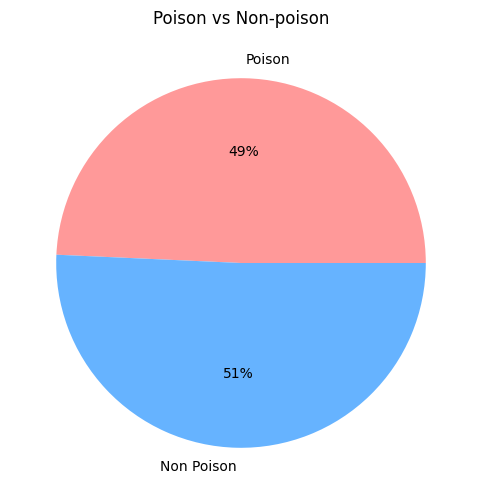

In [109]:
# Assuming 'label' is a boolean column in your DataFrame
sarcastic_counts = df.groupBy("label").count().collect()

# Extract counts
non_sarcastic_count = sarcastic_counts[0]["count"]
sarcastic_count = sarcastic_counts[1]["count"]

# Prepare data for pie chart
labels = ['Poison', 'Non Poison']
sizes = [non_sarcastic_count, sarcastic_count]
colors = ['#ff9999', '#66b3ff']

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=colors)
plt.title('Poison vs Non-poison')

# Display the pie chart
plt.show()


In [110]:
def extract_text(text):
    # Add more patterns as needed
    patterns = {
      r"\bim\b": "i am",
      r"\byoure\b": "you are",
      r"\bhes\b": "he is",
      r"\bshes\b": "she is",
      r"\bwere\b": "we are",
      r"\btheyre\b": "they are",
      r"\bive\b": "i have",
      r"\byouve\b": "you have",
      r"\bweve\b": "we have",
      r"\btheyve\b": "they have",
      r"\bwasnt\b": "was not",
      r"\bwont\b": "will not",
      r"\bcant\b": "cannot",
      r"\bdont\b": "do not",
      r"\bdoesnt\b": "does not",
      r"\bdidnt\b": "did not",
      r"\bhavent\b": "have not",
      r"\bhasnt\b": "has not",
      r"\bhadnt\b": "had not",
      r"\barent\b": "are not",
      r"\bwerent\b": "were not",
      r"\bisnt\b": "is not",
      r"\byoull\b": "you will",
      r"\bwell\b": "we will",
      r"\btheyll\b": "they will",
      r"\bill\b": "i will",
      r"\bhell\b": "he will",
      r"\bshell\b": "she will",
      r"\bitll\b": "it will",
      r"\bshed\b": "she would",
      r"\bhed\b": "he would",
      r"\bid\b": "i would",
      r"\byoud\b": "you would",
      r"\bwed\b": "we would",
      r"\btheyd\b": "they would",
      r"\bcouldve\b": "could have",
      r"\bshouldve\b": "should have",
      r"\bwouldve\b": "would have",
      r"\bwhos\b": "who is",
      r"\bwhats\b": "what is",
      r"\bwheres\b": "where is",
      r"\bwhens\b": "when is",
      r"\bwhys\b": "why is",
      r"\bhows\b": "how is",
      r"\bwhod\b": "who would",
      r"\bwhatd\b": "what would",
      r"\bwhered\b": "where would",
      r"\bwhend\b": "when would",
      r"\bwhyd\b": "why would",
      r"\bhowd\b": "how would",
      r"\bwholl\b": "who will",
      r"\bwhatll\b": "what will",
      r"\bwherell\b": "where will",
      r"\bwhenll\b": "when will",
      r"\bwhyll\b": "why will",
      r"\bhowll\b": "how will",
      r"\bwhore\b": "who are",
      r"\bwhatre\b": "what are",
      r"\bwherere\b": "where are",
      r"\bwhenre\b": "when are",
      r"\bwhyre\b": "why are",
      r"\bhowre\b": "how are",
      r"\bthats\b": "that is",
      r"\bthiss\b": "this is",
      r"\btheres\b": "there is",
      r"\bheres\b": "here is",
      r"\bits\b": "it is",
      r"\bwhove\b": "who have",
      r"\bwhatve\b": "what have",
      r"\bwhereve\b": "where have",
      r"\bwhenve\b": "when have",
      r"\bwhyve\b": "why have",
      r"\bhowve\b": "how have",
      r"\bimma\b": "i am going to",
      r"\bgonna\b": "going to",
      r"\bgotta\b": "got to",
      r"\bwanna\b": "want to",
      r"\bhafta\b": "have to",
      r"\bkinda\b": "kind of",
      r"\bsorta\b": "sort of",
      r"\blemme\b": "let me",
      r"\boutta\b": "out of",
      r"\bgotcha\b": "got you",
      # add more contractions and their expanded forms
    }

    # Function to apply substitution to each token in the array
    def process_token(token):
       for pattern, replacement in patterns.items():
           token = re.sub(pattern, replacement, token)
       return token

    processed_text = process_token(text)

    return processed_text


# Register the function as a UDF (User Defined Function)
extract_text_udf = udf(extract_text, StringType())

# Apply the UDF to the 'filtered_words' column (or the column you want to extract text from)
df = df.withColumn('extracted_text', extract_text_udf('text'))


In [111]:
tokenizer = Tokenizer(inputCol="extracted_text", outputCol="tokened")
df = tokenizer.transform(df)

In [112]:
nltk.download('stopwords')
stopwords_remover = StopWordsRemover(inputCol="tokened", outputCol="filtered")

# Fit and transform the DataFrame
df = stopwords_remover.transform(df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
nltk.download('wordnet')

def penn2morphy(penntag):
   """ Converts Penn Treebank tags to WordNet. """
   morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
   try:
       return morphy_tag[penntag[:2]]
   except:
       return 'n'

def lemmatize(words):
   lemmatizer = WordNetLemmatizer()
   return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
           for word, tag in pos_tag(words)]

lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

df = df.withColumn('lemmatized', lemmatize_udf(df['filtered']))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [114]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [115]:
df.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- extracted_text: string (nullable = true)
 |-- tokened: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lemmatized: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [116]:
def remove_empty_strings(array):
   return [x for x in array if x != '']

remove_empty_strings_udf = udf(remove_empty_strings, ArrayType(StringType()))

df = df.withColumn("lemmatized", remove_empty_strings_udf(df["lemmatized"]))

In [117]:
#df_words = df.select(explode("lemmatized").alias("word"))

# Filter out common words or stop words if necessary
# You can use the 'stopwords' parameter in the WordCloud constructor

# Convert the DataFrame to Pandas for WordCloud generation
#wordcloud_data = df_words.groupBy("word").count().toPandas()

# Generate the WordCloud
#wordcloud = WordCloud(width=800, height=400, background_color="black").generate_from_frequencies(wordcloud_data.set_index("word")["count"].to_dict())

# Display the WordCloud using Matplotlib
#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show()

### Bigram Analyzer

In [118]:
df = spark.createDataFrame(df.collect())

In [131]:
positive_df = df.select('lemmatized').filter(col("label") == 1)
negative_df = df.select('lemmatized').filter(col("label") == 0)

In [132]:
ngram = NGram(n=2, inputCol="lemmatized", outputCol="bigrams")
positive_bigrams = ngram.transform(positive_df)
negative_bigrams = ngram.transform(negative_df)

In [144]:
result_positive = positive_bigrams\
                  .select(explode("bigrams")\
                  .alias("bigram"))\
                  .groupBy("bigram")\
                  .count()\
                  .orderBy(col('count'), ascending=False)
result_positive.show(10)

+----------------+-----+
|          bigram|count|
+----------------+-----+
|       feel like| 5490|
|        want die| 1643|
|       make feel|  933|
|        year old|  905|
|       every day|  869|
|        get good|  853|
|       want kill|  746|
|        year ago|  718|
|         get bad|  671|
|suicidal thought|  659|
+----------------+-----+
only showing top 10 rows



In [145]:
result_negative = negative_bigrams\
                  .select(explode("bigrams")\
                  .alias("bigram"))\
                  .groupBy("bigram")\
                  .count()\
                  .orderBy(col('count'), ascending=False)
result_negative.show(10)

+---------------+-----+
|         bigram|count|
+---------------+-----+
|  filler filler| 2889|
|      feel like|  681|
|          br br|  658|
|gtpoplt gtpoplt|  328|
|       year old|  305|
|    even though|  262|
|      look like|  240|
|     first time|  234|
|    best friend|  211|
|    anyone want|  210|
+---------------+-----+
only showing top 10 rows



### Trigram Analyzer

In [146]:
ngram = NGram(n=3, inputCol="lemmatized", outputCol="bigrams")
positive_trigrams = ngram.transform(positive_df)
negative_trigrams = ngram.transform(negative_df)

In [147]:
result_positive = positive_trigrams\
                  .select(explode("bigrams")\
                  .alias("bigram"))\
                  .groupBy("bigram")\
                  .count()\
                  .orderBy(col('count'), ascending=False)
result_positive.show(10)

+-----------------+-----+
|           bigram|count|
+-----------------+-----+
|    want die want|  247|
|   make feel like|  208|
| every single day|  154|
|   feel like shit|  134|
|     feel like go|  130|
|need someone talk|  122|
|want live anymore|  116|
|   life feel like|  109|
|   thing get well|  105|
|    want end life|  102|
+-----------------+-----+
only showing top 10 rows



In [148]:
result_negative = negative_trigrams\
                  .select(explode("bigrams")\
                  .alias("bigram"))\
                  .groupBy("bigram")\
                  .count()\
                  .orderBy(col('count'), ascending=False)
result_negative.show(10)

+--------------------+-----+
|              bigram|count|
+--------------------+-----+
|filler filler filler| 2656|
|gtpoplt gtpoplt g...|  326|
|         eve eve eve|  167|
|monitor monitor m...|  144|
|      love love love|  121|
|   click click click|  106|
|         pee pee poo|   99|
|       poo poo check|   99|
|         pee poo poo|   99|
|       check pee pee|   98|
+--------------------+-----+
only showing top 10 rows



### Hashing TF-IDF

In [68]:
hashingTF = HashingTF(inputCol="lemmatized", outputCol="rawFeatures", numFeatures=4096)
df = hashingTF.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df)
df = idfModel.transform(df)

In [69]:
df.show(5)

+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|length|      extracted_text|             tokened|            filtered|          lemmatized|         rawFeatures|            features|
+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|music recommendat...|    0|   450|music recommendat...|[music, recommend...|[music, recommend...|[music, recommend...|(4096,[131,178,19...|(4096,[131,178,19...|
|im done trying fe...|    1|   594|i am done trying ...|[i, am, done, try...|[done, trying, fe...|[do, try, feel, b...|(4096,[103,239,28...|(4096,[103,239,28...|
|hey rredflag sure...|    1|   411|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|[hey, rredflag, s...|(4096,[39,46,62,2...|(4096,[39,46,62,2...|
|trying rd time k ...|    0|

In [70]:
df = df.drop('tokened')
df = df.drop('filtered')
df = df.drop('lemmatized')
df = df.drop('extracted_text')
df = df.drop('length')

In [71]:
df.show(5)

+--------------------+-----+--------------------+--------------------+
|                text|label|         rawFeatures|            features|
+--------------------+-----+--------------------+--------------------+
|music recommendat...|    0|(4096,[131,178,19...|(4096,[131,178,19...|
|im done trying fe...|    1|(4096,[103,239,28...|(4096,[103,239,28...|
|hey rredflag sure...|    1|(4096,[39,46,62,2...|(4096,[39,46,62,2...|
|trying rd time k ...|    0|(4096,[95,613,273...|(4096,[95,613,273...|
|got told im lot p...|    0|(4096,[353,433,45...|(4096,[353,433,45...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [72]:
(train, test) = df.randomSplit([0.8,0.2], seed=2023)

In [73]:
train = spark.createDataFrame(train.collect())

In [74]:
gb = GBTClassifier(labelCol = 'label', featuresCol = 'features', seed=2023, maxMemoryInMB=2048, checkpointInterval = 1)

### Hyper Parameter Tuning

In [75]:
gb.setMaxIter(200);
gb.setStepSize(0.030);
gb.setSubsamplingRate(0.6);
gb.setMaxDepth(5);
gb.setMaxBins(32);
gb.setFeatureSubsetStrategy('auto');

In [76]:
model = gb.fit(train)

In [77]:
predictions = model.transform(test)

In [78]:
predictions.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
| anyone wanna cha...|    0|(4096,[237,316,35...|(4096,[237,316,35...|[0.67301585854262...|[0.79348010524299...|       0.0|
| caliber put down...|    1|(4096,[175,358,41...|(4096,[175,358,41...|[0.78739729980847...|[0.82846604253336...|       0.0|
| dollar sucky suc...|    0|(4096,[116,466,13...|(4096,[116,466,13...|[0.97724566921396...|[0.87593555129316...|       0.0|
| hours i hopeim i...|    1|(4096,[109,125,12...|(4096,[109,125,12...|[-1.5330561202988...|[0.04452693696951...|       1.0|
| hours much read ...|    1|(4096,[127,322,41...|(4096,[127,322,41...|[0.72251358446962...|[0.80923193041697...|       0.0|
+-------

In [79]:
pred_result = predictions.collect()

In [80]:
pred_df = spark.createDataFrame(pred_result)

In [81]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'label')

In [82]:
# Extract labels and predictions as lists
labels = labels = pred_df.select("label").rdd.map(lambda x: x[0]).collect()
predicted_labels = labels = pred_df.select("prediction").rdd.map(lambda x: x[0]).collect()
# Find unique labels
unique_labels = sorted(set(labels + predicted_labels))

# Create a confusion matrix
conf_matrix = [[0] * len(unique_labels) for _ in range(len(unique_labels))]

for true_label, pred_label in zip(labels, predicted_labels):
    conf_matrix[int(true_label)][int(pred_label)] += 1

# Display the confusion matrix
print("Confusion Matrix:")
for row in conf_matrix:
    print(row)

Confusion Matrix:
[3037, 0]
[0, 2522]


In [83]:
# Calculate precision, recall, F1 score, and accuracy
precision = evaluator.evaluate(pred_df, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(pred_df, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(pred_df, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_df, {evaluator.metricName: "accuracy"})

# Display the classification report
print("Classification Report:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
Precision: 0.8632
Recall: 0.8617
F1 Score: 0.8614
Accuracy: 0.8617


In [84]:
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(pred_df, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC:", auc)

Area Under ROC: 0.9384637102309663


# Result

In [85]:
# create predict one
def predict_one(text):
    df_one = spark.createDataFrame([(text,)], ['text'])
    # remove symbols with regex
    df_one = df_one.withColumn('text', regexp_replace(col('text'), '[^\sa-zA-Z0-9]', ''))
    # lowercase
    df_one = df_one.withColumn('text', lower(col('text')))
    # extract text
    df_one = df_one.withColumn('extracted_text', extract_text_udf('text'))
    df_one = tokenizer.transform(df_one)
    df_one = stopwords_remover.transform(df_one)
    df_one = df_one.withColumn('lemmatized', lemmatize_udf(df_one['filtered']))
    df_one = hashingTF.transform(df_one)
    df_one = idfModel.transform(df_one)
    return model.transform(df_one).collect()[0]['prediction']


In [86]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: extremely extraordinary collectible
The input suggests negative mental health


In [88]:
user_input = input("Enter a sentence: ")
prediction = predict_one(user_input)
if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")

Enter a sentence: i want to kill myself
The input suggests positive mental health.


In [89]:
model.save('model')

In [90]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/treesMetadata/ (stored 0%)
  adding: model/treesMetadata/_SUCCESS (stored 0%)
  adding: model/treesMetadata/part-00000-96da8635-37c0-4c58-aa30-5972bb1a2a44-c000.snappy.parquet (deflated 25%)
  adding: model/treesMetadata/.part-00000-96da8635-37c0-4c58-aa30-5972bb1a2a44-c000.snappy.parquet.crc (stored 0%)
  adding: model/treesMetadata/._SUCCESS.crc (stored 0%)
  adding: model/metadata/ (stored 0%)
  adding: model/metadata/_SUCCESS (stored 0%)
  adding: model/metadata/.part-00000.crc (stored 0%)
  adding: model/metadata/._SUCCESS.crc (stored 0%)
  adding: model/metadata/part-00000 (deflated 49%)
  adding: model/data/ (stored 0%)
  adding: model/data/_SUCCESS (stored 0%)
  adding: model/data/._SUCCESS.crc (stored 0%)
  adding: model/data/.part-00000-cdf90b43-d811-4a5d-9a95-d910cb920b2c-c000.snappy.parquet.crc (stored 0%)
  adding: model/data/part-00000-cdf90b43-d811-4a5d-9a95-d910cb920b2c-c000.snappy.parquet (deflated 7%)
